This follows using the docker with NMR software at: https://github.com/tlinnet/docker_relax/blob/master/README.md

* [nmrglue examples](https://github.com/jjhelmus/nmrglue/tree/master/examples)
* [nmrglue archive](https://code.google.com/archive/p/nmrglue/downloads)

[This example](https://github.com/jjhelmus/nmrglue/tree/master/examples/jbnmr_examples/s12-s15_relaxation_analysis) is taken from Listing S12 - S15 in the 2013 JBNMR nmrglue paper. In this example a series of 3D NMRPipe files containing relaxation trajectories for a solid state NMR experment and analyzed.

The code has here been refactored to a complete analysis in JupyterLab.


In [1]:
# Get data. 
#if True:
if False:
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part1.zip
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part2.zip
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part3.zip
    ! curl -O https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/nmrglue/jbnmr_s12-s15_relaxation_analysis_part4.zip

In [2]:
# Unpack data
#if True:
if False:
    ! unzip jbnmr_s12-s15_relaxation_analysis_part1.zip
    ! unzip jbnmr_s12-s15_relaxation_analysis_part2.zip
    ! unzip jbnmr_s12-s15_relaxation_analysis_part3.zip
    ! unzip jbnmr_s12-s15_relaxation_analysis_part4.zip

In [3]:
# See dowloaded files and unzip directory
%ls

ft2_files.ls
jbnmr_s12-s15_relaxation_analysis_part1.zip
jbnmr_s12-s15_relaxation_analysis_part2.zip
jbnmr_s12-s15_relaxation_analysis_part3.zip
jbnmr_s12-s15_relaxation_analysis_part4.zip
relaxation_analysis.ipynb
s12-s15_relaxation_analysis/
test.tab


In [4]:
# See dowloaded files in the unzip directory
%ls s12-s15_relaxation_analysis

README.rst  data/            fit_exp.py     plot_trajectories.py  spectra.in
boxes.in    extract_traj.py  plot_boxes.py  relaxation_times.in


In [5]:
# Have a look at the data folder
%ls s12-s15_relaxation_analysis/data

Ytau_100.fid/      Ytau_1500000.fid/  Ytau_3000000.fid/  Ytau_750000.fid/
Ytau_100000.fid/   Ytau_2000000.fid/  Ytau_4000000.fid/
Ytau_1000000.fid/  Ytau_250000.fid/   Ytau_500000.fid/


In [73]:
# Get order of data. 
# https://www.safaribooksonline.com/blog/2014/02/12/using-shell-commands-effectively-ipython/
#%ls -v -d -1 s12-s15_relaxation_analysis/data/*/*.ft2
!ls -v -d -1 s12-s15_relaxation_analysis/data/*/*.ft2 > ft2_files.ls

with open('ft2_files.ls', "r") as f:
    fid_files = f.read().splitlines()

# Get some info
fid_file1 = fid_files[0]
!showApod $fid_file1
!showhdr $fid_file1

# Calculate the Larmor frequency for proton
# http://bio.groups.et.byu.net/LarmourFreqCal.phtml
# http://web.mit.edu/speclab/www/Facility/nmrfreq.html
w0_15N = 50.64699 # Larmor frequency for 15N [MHz]
g_15N = 4.317267 # Gyromagnetic Ratio for 15N [MHz/T]
B0 = w0_15N / g_15N # Magnet Field Strength [T]
g_1H = 42.57748 # Gyromagnetic Ratio for 1H [MHz/T]
w0_1H = g_1H*B0 # Larmor frequency for 15N [MHz]
print("Spectrometer frequency %.3f in 1H MHz"%w0_1H)    
    
fid_times = []
fid_rmsd = []
lines = []
print("\nPath to .ft2, time in us, rmsd noise")
for fid in fid_files:
    time = int(fid.split("Ytau_")[-1].split(".fid")[0])
    # Get output from showApod
    showApod_out = !showApod $fid | grep "REMARK Automated Noise Std Dev in Processed Data:"
    # Get noise
    rmsd = showApod_out[0].split(" ")[-1]
    # Collect
    lines.append("%s %s %s %.3f"%(fid, time, rmsd, w0_1H))
    print(lines[-1])
    fid_times.append(time)
    fid_rmsd.append(rmsd)

# Store info
with open('ft2_files_info.txt', "w") as f:
    for line in lines:
        f.write(line + "\n")


REMARK Effect of Processing on Peak Parameters and Noise for s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2
REMARK Automated Noise Std Dev in Processed Data: 3556.26
REMARK Noise Std Dev Before Processing C13 and N15: 13.5848

VARS   AXIS LABEL  TSIZE FSIZE LW_ADJ LW_FINAL HI_FACTOR VOL_FACTOR SIGMA_FACTOR
FORMAT %s   %-8s   %4d   %4d   %7.4f  %7.4f    %.4e      %.4e       %.4e

       X    C13     1500  8192 1.1033 6.9883   2.4234e-03 2.4718e-04 3.3248e-02
       Y    N15      128  2048 2.9694 20.3856   2.8449e-02 9.8873e-04 1.1490e-01
FILE: s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 DIM: 2 QUAD: Real 2DMODE: States Not Transposed
BYTES: 67110912 PRED: 67110912 MIN: 0 MAX: 0 VALID: 0
ORDER: 2 1 PIPE: 0 CUBE: 0 FILES: 1 8192x2048x1

               X-Axis        Y-Axis   

DATA SIZE:          8192         2048
APOD SIZE:          1500          128
SW Hz:      50000.000000  5000.000000
OBS MHz:      125.690002    50.647999
ORIG Hz:    -2746.765625  3681.497070
DOMAIN:

In [74]:
# See file
! head -n 4 ft2_files_info.txt

s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 100 3556.26 499.488
s12-s15_relaxation_analysis/data/Ytau_100000.fid/test.ft2 100000 3517.99 499.488
s12-s15_relaxation_analysis/data/Ytau_250000.fid/test.ft2 250000 3513.73 499.488
s12-s15_relaxation_analysis/data/Ytau_500000.fid/test.ft2 500000 3544.81 499.488


In [51]:
# Get a test peak list with NMRPipe
ftfile = "s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2"
# Auto detect peaks
! peakHN.tcl -in s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2 -out test.tab




ROI Name='s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2' Length: 16824335 Orig Dim: 2 Dim: 2

ROI X: X_AXIS 1 -> 8195 8195 Pts 1 -> 8195
 Offset: 0 Align=None(0.000,0.000) Window: None
ROI Y: Y_AXIS 1 -> 2053 2053 Pts 1 -> 2053
 Offset: 0 Align=None(0.000,0.000) Window: None

PkROI: 2D Peak Detection, (8195)(2053) points.
PkROI: Detecting peaks ...
PkROI: Finding mask ...
PkROI: Finished detection, 96 new peaks.
PkROI: Truncation artifact (sinc) detection.
PkROI: Found 10 sinc artifacts.
PkROI: Updating clusters ...
PkROI: Writing Peak Table, 86 peaks ...
PkROI: Exiting.



In [52]:
# See the files
! head -n 20 test.tab | nl -ba

     1	REMARK ROI 2D Peak Detection System, File: s12-s15_relaxation_analysis/data/Ytau_100.fid/test.ft2
     2	REMARK Detection Levels: -20847.7 and 20847.7
     3	REMARK Detection: X(+/-2) Y(+/-4)
     4	REMARK Interpolation: X(+/-2) Y(+/-4)
     5	REMARK Noise: 2978.24, Chi2-Threshold: 1.000000e-04, Local Adjustment: None
     6	REMARK Position Tolerances: X(2.0) Y(2.0)
     7	REMARK Sinc Detect ON, Height Adjustments: X(1.200) Y(1.800)
     8	REMARK Sinc Detect Linewidths: X(15.0Hz) Y(0.0Hz)
     9	REMARK Total Peaks: 86, Good Peaks: 86, Questionable Peaks: 0
    10	REMARK Clusters: 55, Max Cluster Size: 14
    11	REMARK ROI Spectral Axis Limits:
    12	
    13	DATA  X_AXIS C13          1  8195  375.902ppm  -21.999ppm
    14	DATA  Y_AXIS N15          1  2053  171.360ppm   72.447ppm
    15	
    16	VARS   INDEX X_AXIS Y_AXIS DX DY X_PPM Y_PPM X_HZ Y_HZ XW YW XW_HZ YW_HZ X1 X3 Y1 Y3 HEIGHT DHEIGHT VOL PCHI2 TYPE ASS CLUSTID MEMCNT
    17	FORMAT %5d %9.3f %9.3f %6.3f %6.3f %8.3f %8.3f 

In [53]:
# Plot the first spectrum. 
# Made from https://github.com/jjhelmus/nmrglue/wiki/Plot-and-integrate-peaks-from-nmrpipe-format-and-sparky-list
# https://github.com/jjhelmus/nmrglue/blob/master/examples/jbnmr_examples/s12-s15_relaxation_analysis/plot_boxes.py
# https://github.com/jjhelmus/nmrglue/blob/master/nmrglue/fileio/pipe.py
import nmrglue as ng

# Read the data
dic, data = ng.pipe.read(ftfile)
# Does not work?
# peakfile = ng.fileio.pipe.read_table("test.tab")

# Read peak file with pandas instead.
import pandas as pd
col_n = ['INDEX', 'X_AXIS', 'Y_AXIS', 'DX', 'DY', 'X_PPM', 'Y_PPM', 'X_HZ', 'Y_HZ', 'XW', 'YW', 'XW_HZ', 'YW_HZ', 'X1', 'X3', 'Y1', 'Y3', 'HEIGHT', 'DHEIGHT', 'VOL', 'PCHI2', 'TYPE', 'ASS', 'CLUSTID', 'MEMCNT']
peakfile = df = pd.read_csv('test.tab', delim_whitespace=True, skiprows=18, names=col_n)
peakfile[['INDEX', 'X_AXIS', 'Y_AXIS', 'X_PPM', 'Y_PPM']].head()


,INDEX,X_AXIS,Y_AXIS,X_PPM,Y_PPM
0,1,4826.972,784.264,141.553,133.604
1,2,4836.181,783.691,141.105,133.632
2,3,4846.570,784.339,140.601,133.601
3,4,4852.329,783.781,140.321,133.628
4,5,4862.333,783.502,139.835,133.641


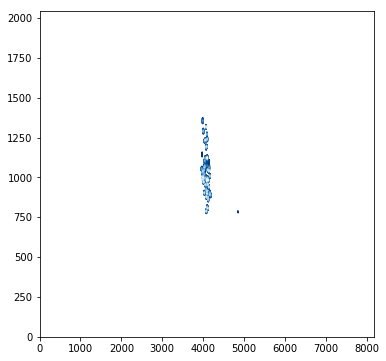

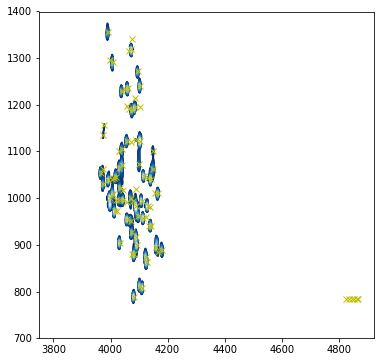

In [55]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot parameters
cmap = matplotlib.cm.Blues_r    # contour map (colors to use for contours)
contour_start = 30000           # contour level start value
contour_num = 20                # number of contour levels
contour_factor = 1.20           # scaling factor between contour levels
## calculate contour levels
cl = [contour_start * contour_factor ** x for x in range(contour_num)]
# Make figures
f1, ax1 = plt.subplots(1, figsize=(6, 6))
f2, ax2 = plt.subplots(1, figsize=(6, 6))

if True:
    ax1.contour(data, cl, cmap=cmap, extent=(0, data.shape[1]-1, 0, data.shape[0]-1))

    # Limit show
    x0 = 3750
    x1 = 4250
    y0 = 700
    y1 = 1400
    xpad = 0
    ypad = 0
    if x0 > x1:
        x0, x1 = x1, x0
    if y0 > y1:
        y0, y1 = y1, y0

    # slice the data around the peak
    dataslice = data[y0 - ypad:y1 + 1 + ypad, x0 - xpad:x1 + 1 + xpad]
    extent = (x0 - xpad + 1, x1 + xpad - 1, y0 - ypad + 1, y1 + ypad - 1)
    ax2.contour(dataslice, cl, cmap=cmap, extent=extent)

    # Plot points
    ptsX=peakfile['X_AXIS']
    ptsY=peakfile['Y_AXIS']
    ax2.plot(ptsX, ptsY, "x", color='y')

In [12]:
# Make a measurement of the peaks. https://spin.niddk.nih.gov/NMRPipe/ref/prog/seriestab.html
! seriesTab -in test.tab -out test.ser -list ft2_files.ls -max -dx 1 -dy 1

In [14]:
# See output
! head -n 15 test.ser | nl -ba

     1	REMARK SeriesTab Input: test.tab Output: test.ser
     2	REMARK Mode: Maximum Dimensions: 2
     3	REMARK Input Region:    X +/- 1 X-ZF: 3
     4	REMARK Analysis Region: X +/- 1
     5	REMARK Input Region:    Y +/- 1 Y-ZF: 3
     6	REMARK Analysis Region: Y +/- 1
     7	
     8	VARS   INDEX X_AXIS Y_AXIS DX DY X_PPM Y_PPM X_HZ Y_HZ XW YW XW_HZ YW_HZ X1 X3 Y1 Y3 HEIGHT DHEIGHT VOL PCHI2 TYPE ASS CLUSTID MEMCNT Z_A0 Z_A1 Z_A2 Z_A3 Z_A4 Z_A5 Z_A6 Z_A7 Z_A8 Z_A9
     9	FORMAT %5d %9.3f %9.3f %6.3f %6.3f %8.3f %8.3f %9.3f %9.3f %7.3f %7.3f %8.3f %8.3f %4d %4d %4d %4d %+e %+e %+e %.5f %d %s %4d %4d %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f
    10	
    11	NULLVALUE -666
    12	NULLSTRING *
    13	
    14	    1  4826.972   784.264  0.716  4.626  141.553  133.604 17791.740  6766.790   7.113  14.102   43.416   34.429 4822 4829  779  789 -3.068895e+04 +8.669779e+02 -3.066648e+04 0.00000 1 None    1    1  1.0000  0.9673  0.7892  0.6927  0.5555  0.4019  0.4280  0.2652  0.24

In [86]:
# Make a script file for relax
txtout = r"""
from auto_analyses.relax_fit import Relax_fit
 
# Taken from the relax disp manual, section 10.6.1 Dispersion script mode - the sample script
# Create the data pipe.
pipe_name = 'base pipe'
pipe_bundle = 'test'
pipe.create(pipe_name=pipe_name, bundle=pipe_bundle, pipe_type='relax_fit')

# Create the spins
spectrum.read_spins(file="test.ser", dir=None)

# Read the spectrum from NMRSeriesTab file. The "auto" will generate spectrum name of form: Z_A{i}
spectrum.read_intensities(file="test.ser", dir=None, spectrum_id='auto', int_method='height')

# Open the settings file.
set_file = open('ft2_files_info.txt', 'r')

for i, line in enumerate(set_file):
    # Set the current spectrum id
    current_id = "Z_A%s"%(i)
 
    # Get the relax time in seconds instead of us.
    relaxT_i = float(line.split()[1])/1e6
    rmsd_i = float(line.split()[2])
    sfrq_i = float(line.split()[3])
 
    print(relaxT_i, rmsd_i, sfrq_i)
 
    # Set time
    relax_fit.relax_time(time=relaxT_i, spectrum_id=current_id)
 
    # Set noise
    spectrum.baseplane_rmsd(error=rmsd_i, spectrum_id=current_id)
 
    # Set sfrq
    spectrometer.frequency(id=current_id, frq=sfrq_i, units='MHz')

    # Select the relaxation curve type. Also support inversion 'inv' and  saturation recovery experiment 'sat'.
    relax_fit.select_model(model='exp')

state.save("ini_state")
#Relax_fit(pipe_name=pipe_name, pipe_bundle=pipe_bundle, file_root='Rx', results_dir=None, grid_inc=11, mc_sim_num=50, view_plots=False)
"""

# write file
with open('relax_01.py', "w") as f:
    f.write(txtout)


In [87]:
# Check the file
! cat relax_01.py


from auto_analyses.relax_fit import Relax_fit
 
# Taken from the relax disp manual, section 10.6.1 Dispersion script mode - the sample script
# Create the data pipe.
pipe_name = 'base pipe'
pipe_bundle = 'test'
pipe.create(pipe_name=pipe_name, bundle=pipe_bundle, pipe_type='relax_fit')

# Create the spins
spectrum.read_spins(file="test.ser", dir=None)

# Read the spectrum from NMRSeriesTab file. The "auto" will generate spectrum name of form: Z_A{i}
spectrum.read_intensities(file="test.ser", dir=None, spectrum_id='auto', int_method='height')

# Open the settings file.
set_file = open('ft2_files_info.txt', 'r')

for i, line in enumerate(set_file):
    # Set the current spectrum id
    current_id = "Z_A%s"%(i)
 
    # Get the relax time in seconds instead of us.
    relaxT_i = float(line.split()[1])/1e6
    rmsd_i = float(line.split()[2])
    sfrq_i = float(line.split()[3])
 
    print(relaxT_i, rmsd_i, sfrq_i)
 
    # Set time
    relax_fit.relax_time(time=relaxT_i, spectrum_id=current

In [88]:
# run relax
! relax relax_01.py




                                     relax repository checkout
                              fb4cd881135cbccc6ff3335834c74ae883357330
                           https://github.com/nmr-relax/relax.git (fetch)
                           https://github.com/nmr-relax/relax.git (push)

                              Molecular dynamics by NMR data analysis

                             Copyright (C) 2001-2006 Edward d'Auvergne
                         Copyright (C) 2006-2017 the relax development team

This is free software which you are welcome to modify and redistribute under the conditions of the
GNU General Public License (GPL).  This program, including all modules, is licensed under the GPL
and comes with absolutely no warranty.  For details type 'GPL' within the relax prompt.

Assistance in using the relax prompt and scripting interface can be accessed by typing 'help' within
the prompt.

Processor fabric:  Uni-processor.

script = 'relax_01.py'
--------------------------------------

In [ ]:
# Now open another terminal and open relax in gui
# dre relax -g